# Data Exploration and Visualization

This notebook explores the PPG dataset, focusing on data cleaning, analysis, and visualization techniques. The goal is to understand the structure of the data, identify patterns, and visualize key insights.

## Import Libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.io import loadmat
import scipy.signal as signal

## Load Data

In [3]:
data = loadmat(r'../data/part_1.mat')
print(data.keys())
p = data['p']
p.shape

dict_keys(['__header__', '__version__', '__globals__', 'p'])


(1, 1000)

There seems to be 1000 recordings in this dataset. Each recording has PPG, ABP and ECG signals. Let's plot one of those recordings.

## Plot Raw Data

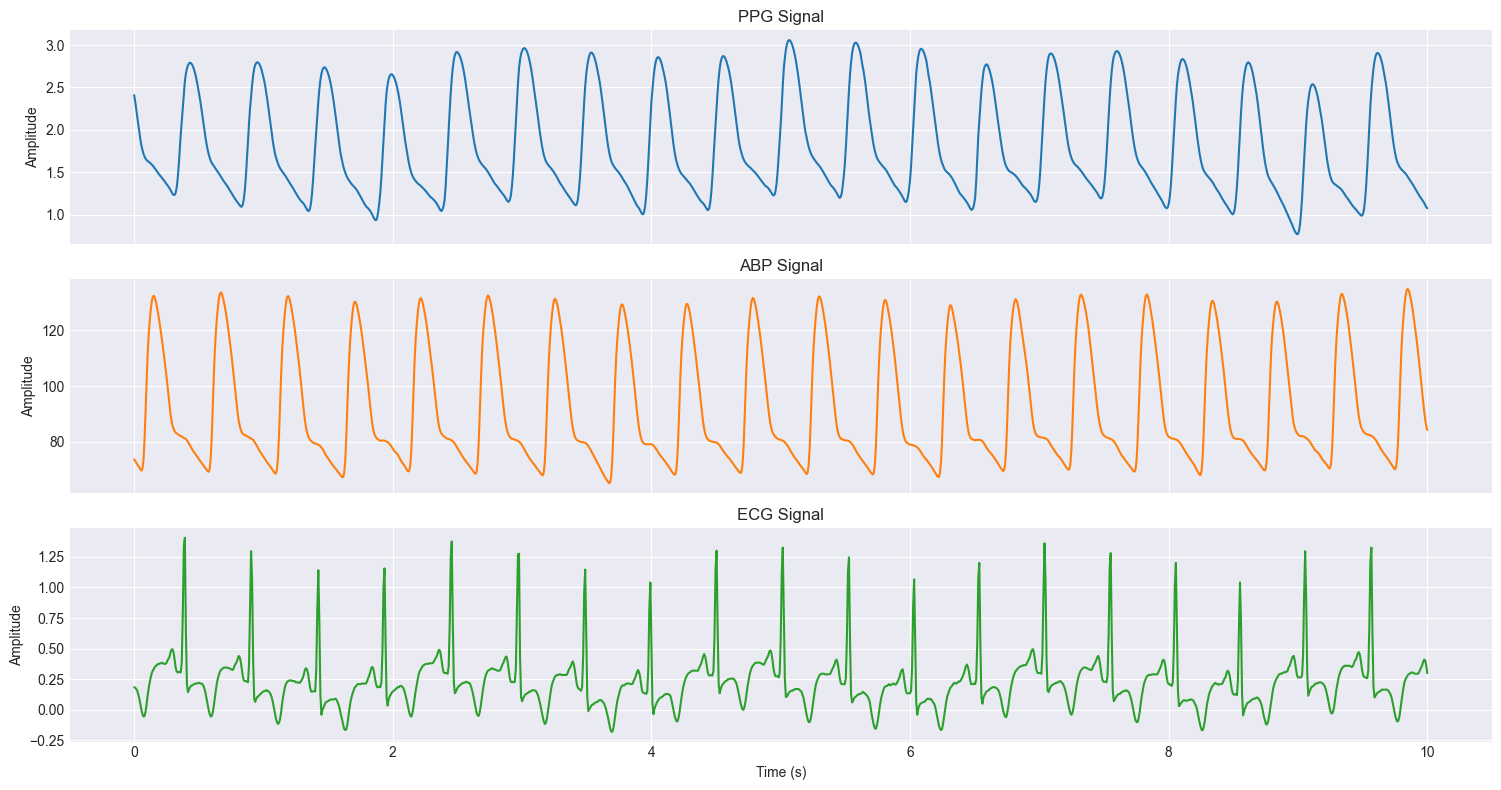

In [60]:
sample = p[0, 1]
fs  = 125 # Sampling frequency
# Create a time vector
time = np.arange(sample.shape[1]) / fs

# Let's zoom in a bit to see the signals more clearly
zoom_start = 0  # in seconds
zoom_end = 10   # in seconds
zoom_indices = (time >= zoom_start) & (time <= zoom_end)

# Set matplotlib style to make plots look nicer
plt.style.use('seaborn-v0_8-darkgrid')

fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
axs[0].plot(time[zoom_indices], sample[0, zoom_indices], color='C0')
axs[0].set_title('PPG Signal')
axs[0].set_ylabel('Amplitude')
axs[1].plot(time[zoom_indices], sample[1, zoom_indices], color='C1')
axs[1].set_title('ABP Signal')
axs[1].set_ylabel('Amplitude')
axs[2].plot(time[zoom_indices], sample[2, zoom_indices], color='C2')
axs[2].set_title('ECG Signal')
axs[2].set_ylabel('Amplitude')
axs[2].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

## Filtering

Let's filter the signals and see if it improves some of the issues. I see some noise and baseline wander in some of the signals.

Here are the filter parameters:
| Signal | Type | Order | Low Cutoff Frequency (Hz) | High Cutoff Frequency (Hz) |
|--------|------|-------|---------------------------|----------------------------|
| PPG    | Butterworth - Bandpass | 4     | 0.5                       | 8                          |
| ABP    | Butterworth - Bandpass | 4     | 0.05                       | 20                         |
| ECG    | Butterworth - Bandpass | 4     | 0.5                       | 40                         |



In [61]:
# Define a bandpass filter

def bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_signal = signal.filtfilt(b, a, sig)
    return filtered_signal

# Filter parameters
order = 4
lowcut_ppg = 0.5
highcut_ppg = 8.0
lowcut_abp = 0.05
highcut_abp = 20.0
lowcut_ecg = 0.5
highcut_ecg = 40.0
 
lowcuts = [lowcut_ppg, lowcut_abp, lowcut_ecg]
highcuts = [highcut_ppg, highcut_abp, highcut_ecg]

filtered_sample = np.zeros_like(sample)
# Filter the sample
for i in range(sample.shape[0]):
    filtered_sample[i, :] = bandpass_filter(sample[i, :], lowcuts[i], highcuts[i], fs, order)

### Plot Filtered Data

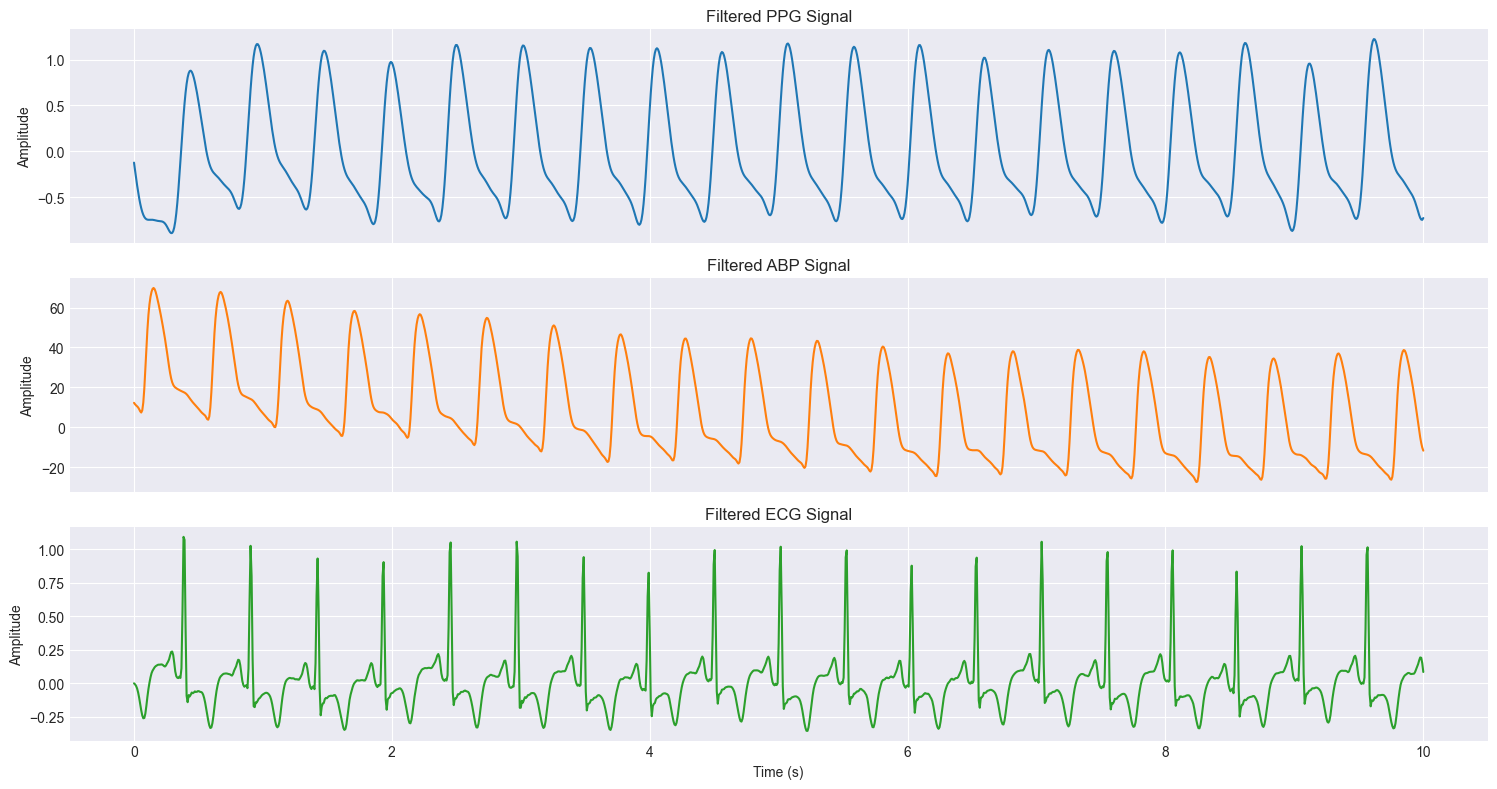

In [62]:
# Plot the fitered signals
fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
axs[0].plot(time[zoom_indices], filtered_sample[0, zoom_indices], color='C0')
axs[0].set_title('Filtered PPG Signal')
axs[0].set_ylabel('Amplitude')
axs[1].plot(time[zoom_indices], filtered_sample[1, zoom_indices], color='C1')
axs[1].set_title('Filtered ABP Signal')
axs[1].set_ylabel('Amplitude')
axs[2].plot(time[zoom_indices], filtered_sample[2, zoom_indices], color='C2')
axs[2].set_title('Filtered ECG Signal')
axs[2].set_ylabel('Amplitude')
axs[2].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

Okay, filtering the ABP signal was a terrible idea :). The PPG and ECG signals look better though. The smart thing to do would be to use raw PPG and ECG data in a model vs filtered data and see which one works better.

## Feature Extraction

Let's extract some features that we'll need. First, we need to extract SBP and DBP from the ABP signal. We can do this by finding the systolic and diastolic peaks in the ABP signal.

### Systolic and Diastolic Peaks

In [54]:
def plot_abp_with_peaks(time, abp_signal, systolic_peaks, diastolic_peaks, sbp_values, dbp_values, 
                        start_time=None, end_time=None):
    """
    Plots the ABP signal with systolic and diastolic peaks.
    If start_time and end_time are not provided, the entire signal is plotted.
    The legend is displayed below the plot.
    """
    
    # Handle default zoom range (plot full signal)
    if start_time is None or end_time is None:
        start_time = np.min(time)
        end_time = np.max(time)
    
    # Create masks for zoom region and valid peaks
    zoom_indices = (time >= start_time) & (time <= end_time)
    zoomed_systolic = (time[systolic_peaks] >= start_time) & (time[systolic_peaks] <= end_time)
    zoomed_diastolic = (time[diastolic_peaks] >= start_time) & (time[diastolic_peaks] <= end_time)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(18, 5))
    
    # Plot ABP and peaks
    ax.plot(time[zoom_indices], abp_signal[zoom_indices], label='ABP Signal', color='C1')
    ax.plot(time[systolic_peaks[zoomed_systolic]], sbp_values[zoomed_systolic], 'ro', label='Systolic Peaks (SBP)')
    ax.plot(time[diastolic_peaks[zoomed_diastolic]], dbp_values[zoomed_diastolic], 'go', label='Diastolic Peaks (DBP)')
    
    # Labels and title
    if start_time == np.min(time) and end_time == np.max(time):
        ax.set_title('ABP Signal with Detected Systolic and Diastolic Peaks (Full Length)')
    else:
        ax.set_title(f'ABP Signal with Detected Systolic and Diastolic Peaks ({start_time:.1f}s–{end_time:.1f}s)')
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(start_time, end_time)
    
    # Move legend outside (bottom center)
    ax.legend(
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),  # position legend just outside the right border
        borderaxespad=0,
        frameon=False
    )
    
    plt.tight_layout()
    plt.show()

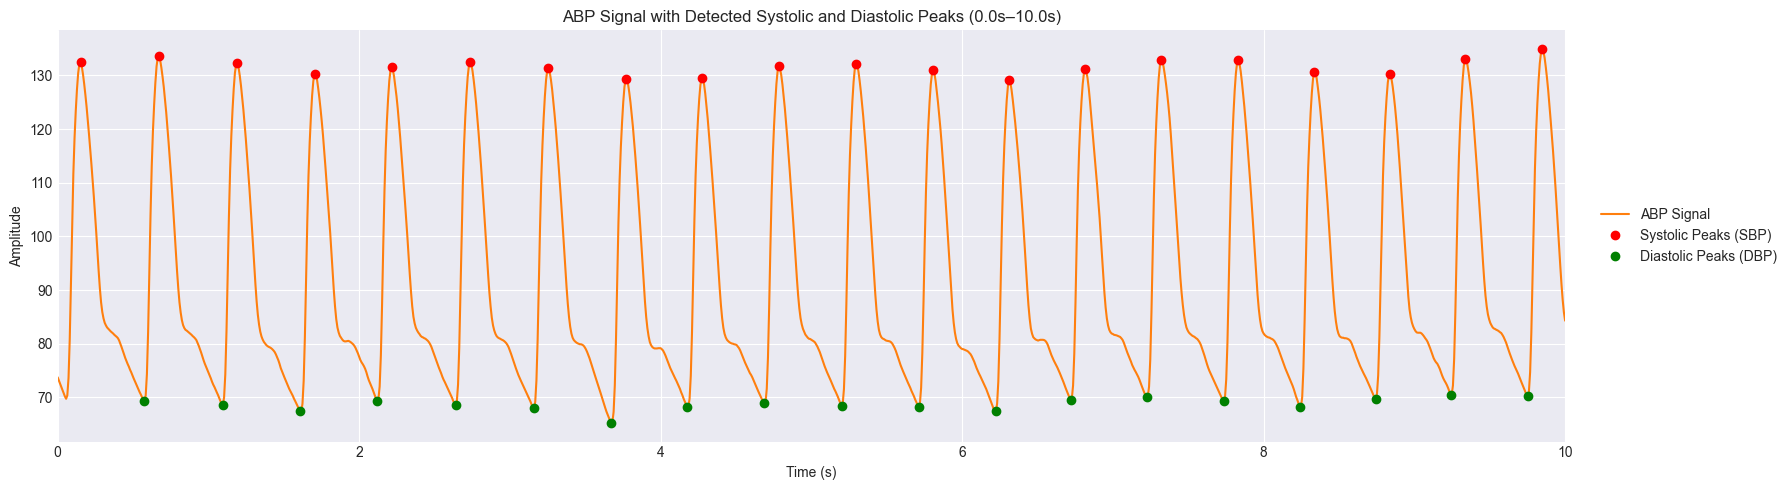

In [63]:
# Extract SBP and DBP from ABP raw signal
abp_signal = sample[1, :]
systolic_peaks, _ = signal.find_peaks(abp_signal, distance=fs*0.2, prominence=20)  # Minimum distance of 0.2 seconds between peaks
diastolic_peaks, _ = signal.find_peaks(-abp_signal, distance=fs*0.2, prominence=20)  # Minimum distance of 0.2 seconds between peaks
sbp_values = abp_signal[systolic_peaks]
dbp_values = abp_signal[diastolic_peaks]

# Plot the ABP signal with detected peaks
plot_abp_with_peaks(time, abp_signal, systolic_peaks, diastolic_peaks, sbp_values, dbp_values, start_time=0, end_time=10)

Interesting. Something seems to be happening between 200-230 seconds. Let's zoom in.

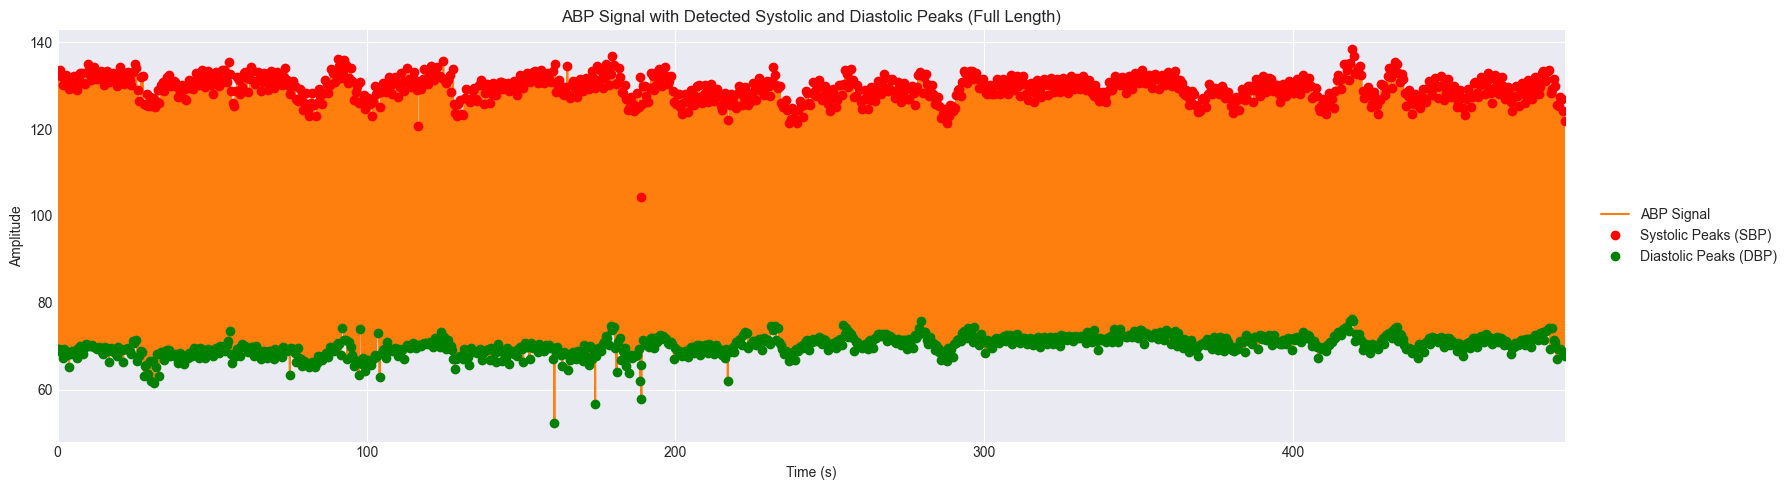

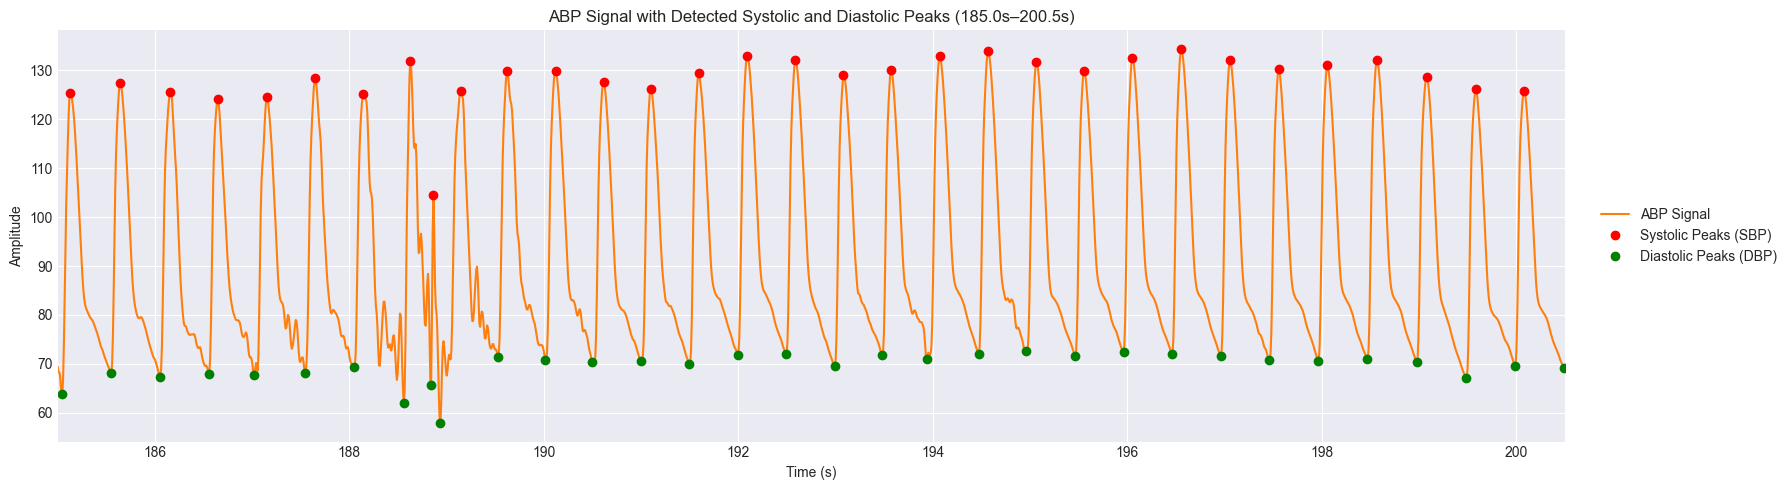

In [71]:
# PLot ABP signal with systolic and diastolic points marked
plot_abp_with_peaks(time, abp_signal, systolic_peaks, diastolic_peaks, sbp_values, dbp_values)
plot_abp_with_peaks(time, abp_signal, systolic_peaks, diastolic_peaks, sbp_values, dbp_values, start_time=185, end_time=200.5)



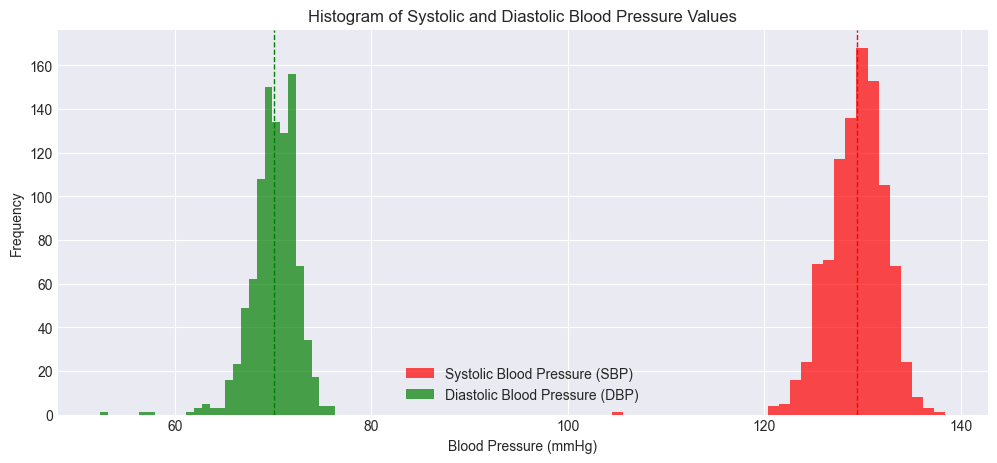

In [74]:
# PLot a histogram of SBP and DBP values with a vline at mean value
plt.figure(figsize=(12, 5))
plt.hist(sbp_values, bins=30, alpha=0.7, label='Systolic Blood Pressure (SBP)', color='r')
plt.axvline(np.mean(sbp_values), color='r', linestyle='dashed', linewidth=1)
plt.hist(dbp_values, bins=30, alpha=0.7, label='Diastolic Blood Pressure (DBP)', color='g')
plt.axvline(np.mean(dbp_values), color='g', linestyle='dashed', linewidth=1)
plt.title('Histogram of Systolic and Diastolic Blood Pressure Values')
plt.xlabel('Blood Pressure (mmHg)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

This seems to work fine. But a better approach may be to detect diastolic peaks as min() between systolic peaks. This will ensure that we always have a diastolic peak between two systolic peaks.

### Alternate peak detection approach

In [ ]:
# Detect systolic peaks using find_peaks. 
systolic_peaks, _ = signal.find_peaks(abp_signal, distance=fs*0.2, prominence=20)  # Minimum distance of 0.2 seconds between peaks
# Detect diastolic peaks as the minimum point between each pair of systolic peaks
diastolic_peaks = []
for i in range(len(systolic_peaks) - 1):
    start = systolic_peaks[i]
    end = systolic_peaks[i + 1]
    if end > start:  # Ensure valid range
        diastolic_peak = start + np.argmin(abp_signal[start:end])
        diastolic_peaks.append(diastolic_peak)
diastolic_peaks = np.array(diastolic_peaks)
# Get SBP and DBP values
sbp_values = abp_signal[systolic_peaks]
dbp_values = abp_signal[diastolic_peaks]


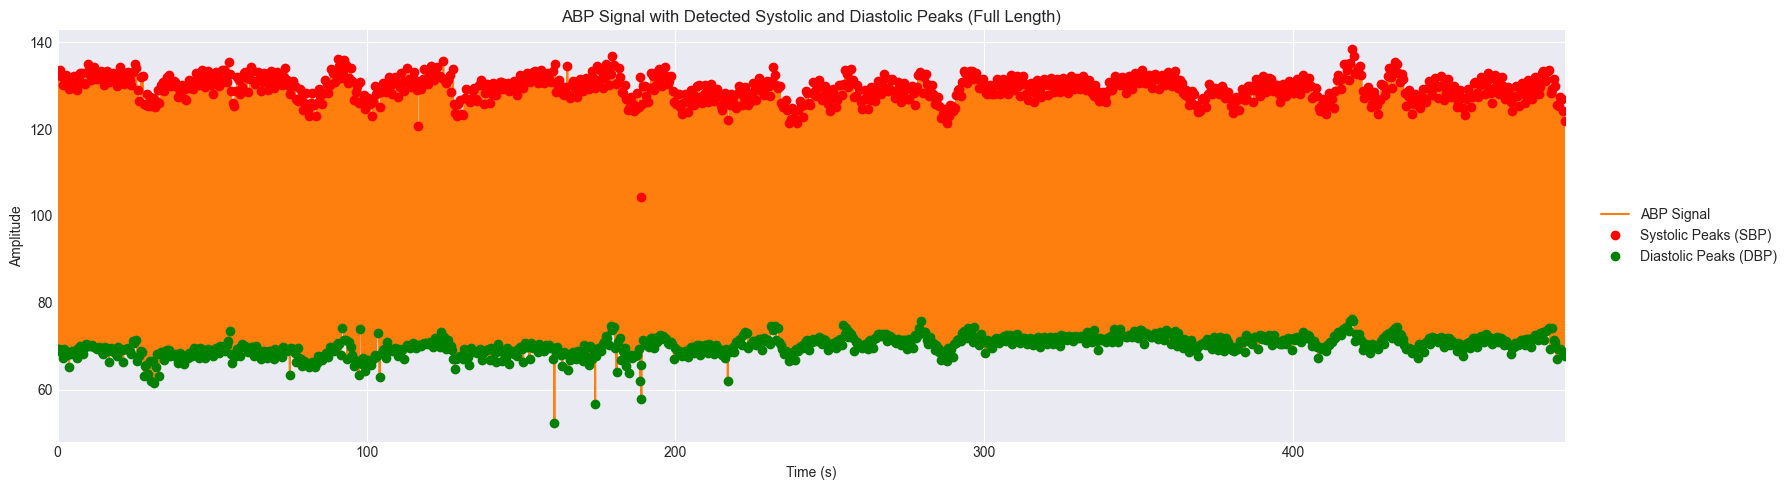

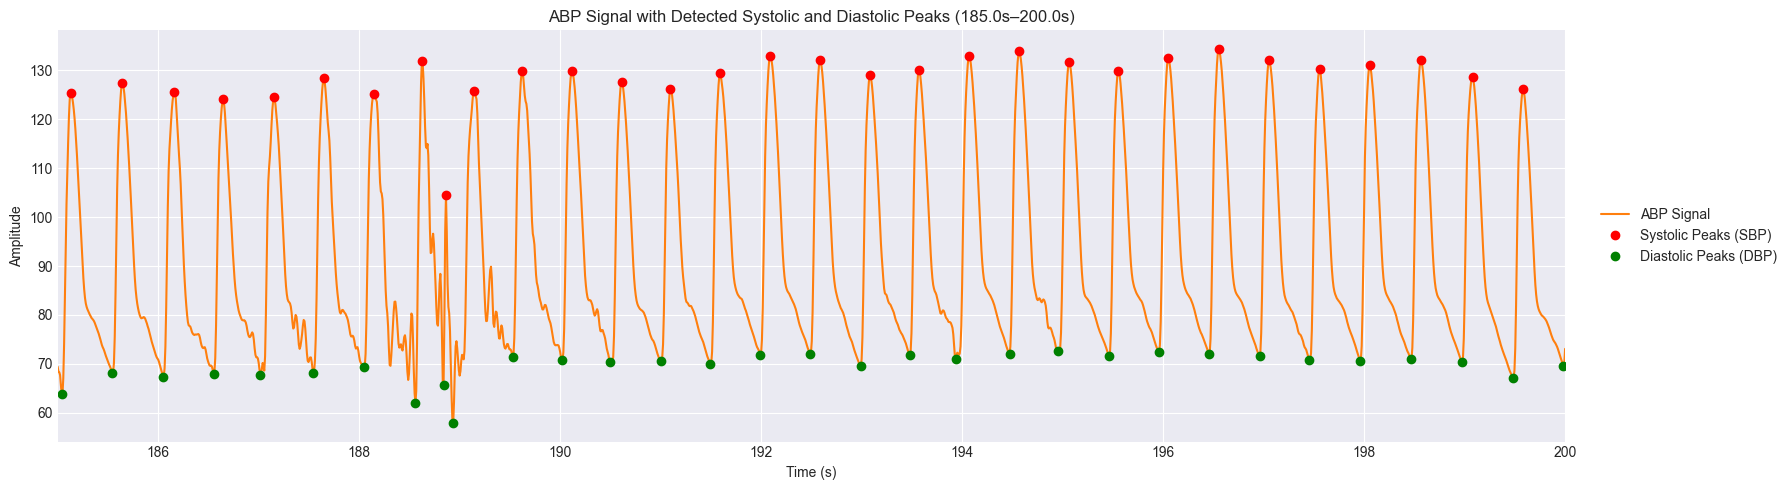

In [70]:
# PLot the signal with detected peaks
plot_abp_with_peaks(time, abp_signal, systolic_peaks, diastolic_peaks, sbp_values, dbp_values)
plot_abp_with_peaks(time, abp_signal, systolic_peaks, diastolic_peaks, sbp_values, dbp_values, start_time=185, end_time=200)

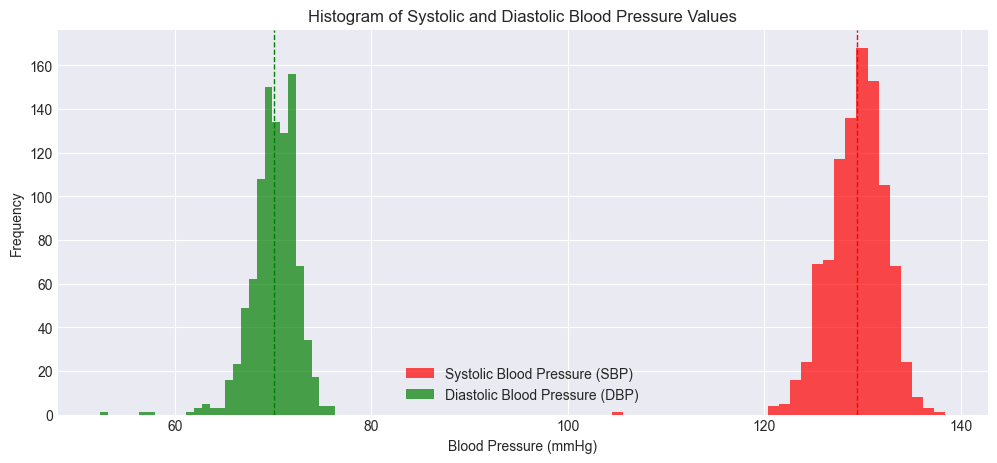

In [73]:
# PLot a histogram of SBP and DBP values with a vline at mean value
plt.figure(figsize=(12, 5))
plt.hist(sbp_values, bins=30, alpha=0.7, label='Systolic Blood Pressure (SBP)', color='r')
plt.axvline(np.mean(sbp_values), color='r', linestyle='dashed', linewidth=1)
plt.hist(dbp_values, bins=30, alpha=0.7, label='Diastolic Blood Pressure (DBP)', color='g')
plt.axvline(np.mean(dbp_values), color='g', linestyle='dashed', linewidth=1)
plt.title('Histogram of Systolic and Diastolic Blood Pressure Values')
plt.xlabel('Blood Pressure (mmHg)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Segmentation

Idea is to segment the PPG signals into 3 second windows with 75% overlap. Each segment will have a corresponding SBP and DBP value. The values will be the average of all the SBP and DBP values in that segment.

In [ ]:
# Segment the PPG signals into 3 second windows with 75% overlap

segment_length = 3 * fs  # 3 seconds
overlap = int(0.75 * segment_length)  # 75% overlap
step_size = segment_length - overlap
num_segments = (len(filtered_sample[0]) - overlap) // step_size

segments_ppg = []
segments_sbp = []
segments_dbp = []


for i in range(num_segments):
    start_idx = i * step_size
    end_idx = start_idx + segment_length
    if end_idx <= len(filtered_sample[0]):
        segment = filtered_sample[0, start_idx:end_idx]
        segments_ppg.append(segment)
        # Find SBP and DBP values in this segment
        segment_time = time[start_idx:end_idx]
        segment_systolic = systolic_peaks[(systolic_peaks >= start_idx) & (systolic_peaks < end_idx)]
        segment_diastolic = diastolic_peaks[(diastolic_peaks >= start_idx) & (diastolic_peaks < end_idx)]
        if len(segment_systolic) > 0:
            segments_sbp.append(np.mean(abp_signal[segment_systolic]))
        else:
            segments_sbp.append(np.nan)  # No systolic peak in this segment
        if len(segment_diastolic) > 0:
            segments_dbp.append(np.mean(abp_signal[segment_diastolic]))
        else:
            segments_dbp.append(np.nan)  # No diastolic peak in this segment

segments_ppg = np.array(segments_ppg)
segments_sbp = np.array(segments_sbp)
segments_dbp = np.array(segments_dbp)

print(f'Number of segments: {len(segments_ppg)}')
print(f'Shape of each segment: {segments_ppg[0].shape}')
print(f'Number of segments with valid SBP: {np.sum(~np.isnan(segments_sbp))}')
print(f'Number of segments with valid DBP: {np.sum(~np.isnan(segments_dbp))}')


Number of segments: 645
Shape of each segment: (375,)
Number of segments with valid SBP: 645
Number of segments with valid DBP: 645


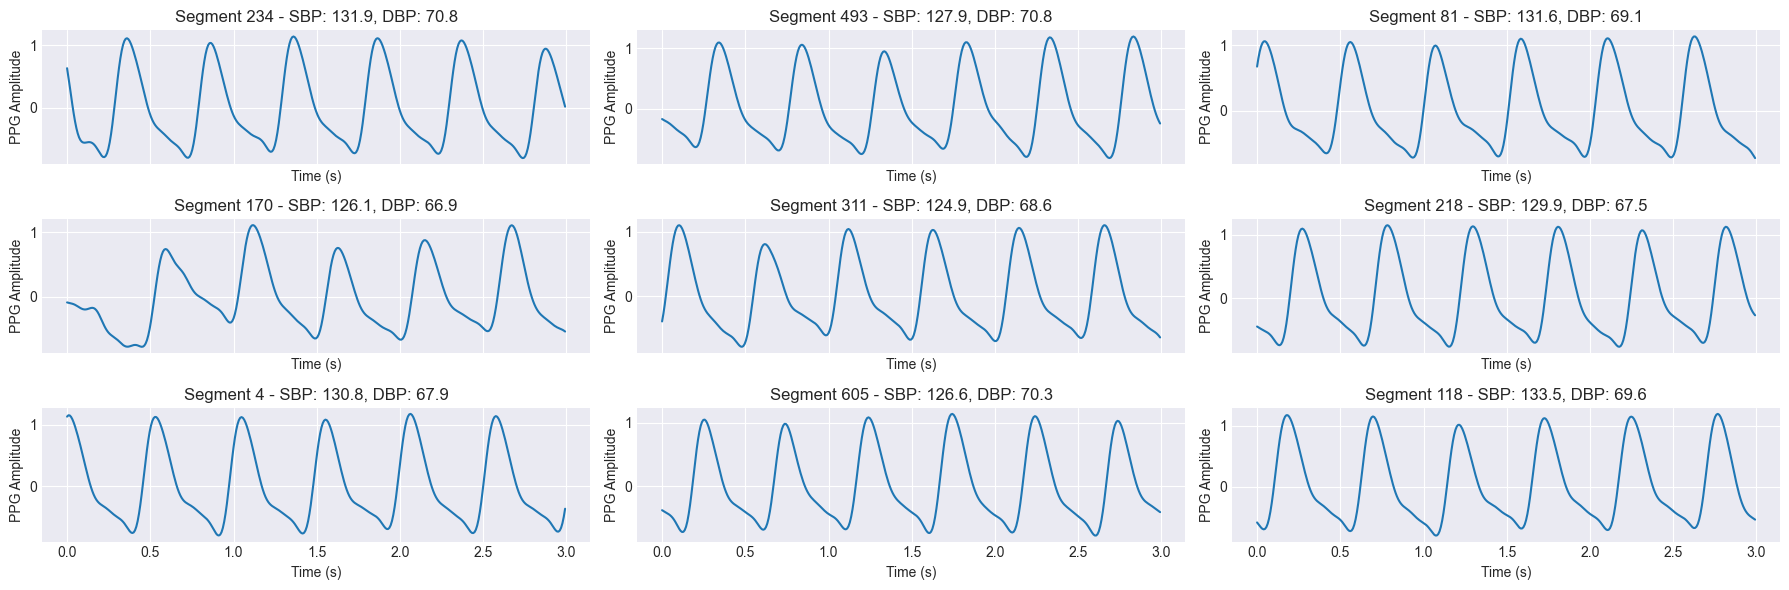

In [78]:
# PLot a randopm collection of segments

fig, ax = plt.subplots(3, 3, figsize=(18, 6), sharex=True)
for i in range(3):
    for j in range(3):
        idx = np.random.randint(0, len(segments_ppg))
        ax[i, j].plot(np.arange(segment_length) / fs, segments_ppg[idx])
        ax[i, j].set_title(f'Segment {idx} - SBP: {segments_sbp[idx]:.1f}, DBP: {segments_dbp[idx]:.1f}')
        ax[i, j].set_xlabel('Time (s)')
        ax[i, j].set_ylabel('PPG Amplitude')
plt.tight_layout()
plt.show()